In [3]:
from 传统动量指标集 import *
from 传统波动率指标集 import *
from 国泰君安指标计算集 import *
from 世宽指标计算集 import *

import pandas as pd
import 计算函数包 as cf
from tqdm.contrib.concurrent import process_map
from multiprocessing import Pool, cpu_count
from functools import partial
import 回测函数包
import importlib
importlib.reload(回测函数包)
from 回测函数包 import *


# 计算jd指标

In [4]:
# 首先计算因子


if __name__ == "__main__":
    feature_compute_funcs = [
        high_low_5days, high_low_17days,

        volume_std_2days, volume_std_11days, volume_std_21days,

        returns_std_3days, returns_std_27days, returns_last_5days, returns_last_18day, returns_last_2days,

        weighted_avg_return_2, weighted_avg_return_42,

        returns_daliy_max_2days, returns_daliy_max_7days, returns_daliy_max_last_20days,

        sma_weight_con_23_37, sma_weight_con_3_62,

        flipping_weight_29_69, flipping_weight_4_67,

        gj_001, gj_002, gj_003, gj_004, gj_005, gj_006, gj_007, gj_008, gj_009, gj_010,
        gj_011, gj_012, gj_013, gj_014, gj_015, gj_016, gj_017, gj_018, gj_019, gj_020,
        gj_021, gj_022, gj_023, gj_024, gj_025, gj_026, gj_027, gj_028, gj_029, gj_031,
        gj_032, gj_033, gj_034, gj_035, gj_036, gj_037, gj_038, gj_039, gj_040, gj_041,
        gj_042, gj_043, gj_044, gj_045, gj_046, gj_047, gj_048, gj_049, gj_050, gj_051,
        gj_052, gj_053, gj_054, gj_056, gj_057, gj_058, gj_059, gj_060, gj_061, gj_062,
        gj_063, gj_064, gj_065, gj_066,

        wq_001, wq_002, wq_003, wq_004, wq_005, wq_006, wq_007, wq_008, wq_009, wq_010,
        wq_011, wq_012, wq_013, wq_014, wq_015, wq_016, wq_017, wq_018, wq_019, wq_020,
        wq_021, wq_022, wq_023, wq_024, wq_025, wq_026, wq_027, wq_028, wq_029, wq_030,
        wq_031, wq_032, wq_033, wq_034, wq_035, wq_036, wq_037, wq_038, wq_039, wq_040,
        wq_041, wq_042, wq_043, wq_044, wq_045, wq_046, wq_047, wq_049, wq_050, wq_051,
        wq_052, wq_053, wq_054, wq_055, wq_057, wq_065, wq_064, wq_060, wq_061, wq_066,
        wq_068, wq_070, wq_071, wq_072, wq_073, wq_074, wq_075, wq_077, wq_078, wq_081,
        wq_083, wq_085
    ]
    # 读取因子名
    feature_names = [func.__name__ for func in feature_compute_funcs]
    df = pd.read_csv("dataset.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.loc[df['huanyue'] != 1]
    df = df.loc[df['date'].dt.dayofweek != 4]
    print("已删除所有周五和所有换月日")

    

    print(df['id'])
    


已删除所有周五和所有换月日
1          A
2          A
3          A
5          A
6          A
          ..
104625    ZN
104626    ZN
104627    ZN
104628    ZN
104629    ZN
Name: id, Length: 79830, dtype: object


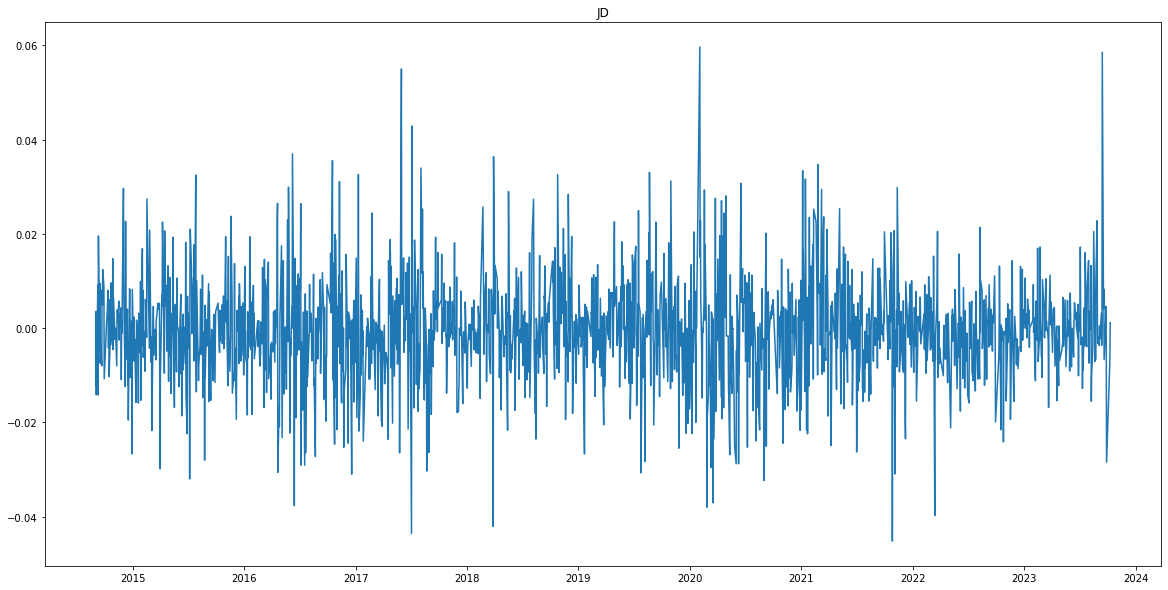

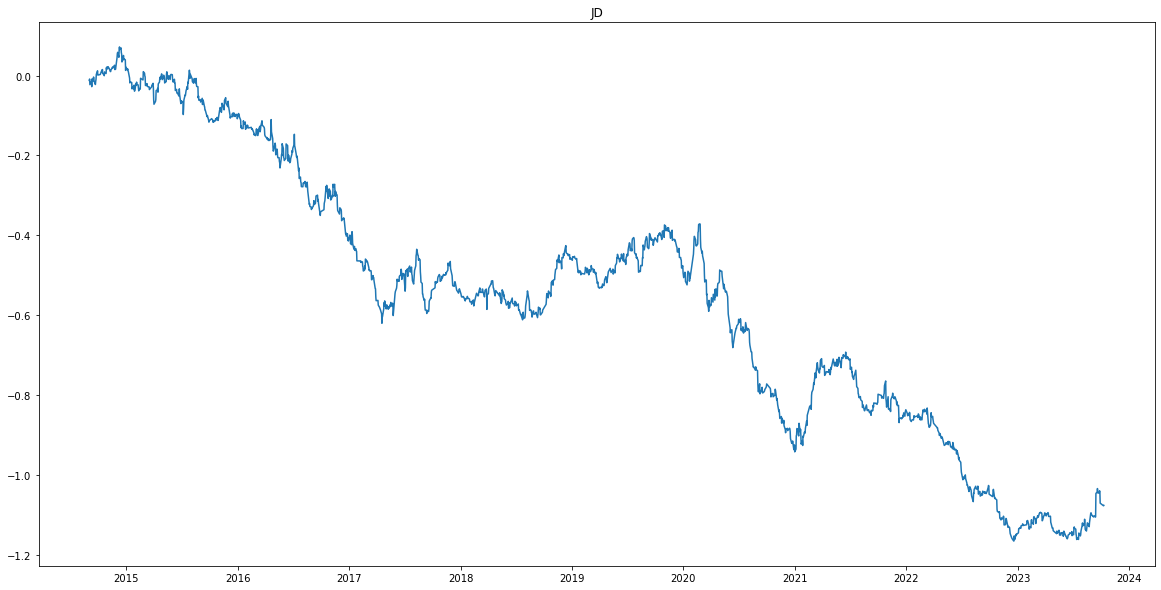

总涨幅为 -1.07644
上涨的概率为 0.4616947185142194
总变化为 13.5463


In [4]:
name = 'JD'
columns_0429 = ['date'] + ['id'] + ['returns'] + ['open', 'close']
df_transaction_subset = df[df['id'] == name][columns_0429]
df_transaction_subset = df_transaction_subset.sort_values('date')
df_transaction_subset = df_transaction_subset.reset_index(drop=True)
df_transaction_subset = df_transaction_subset.dropna()
df_transaction_subset['returns_sign'] = np.sign(df_transaction_subset['returns'])


plt.figure(figsize=(20, 10))
plt.plot(df_transaction_subset['date'], df_transaction_subset['returns'])
plt.title(name)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(df_transaction_subset['date'], df_transaction_subset['returns'].cumsum())
plt.title(name)
plt.show()

print("总涨幅为", df_transaction_subset['returns'].sum())
print("上涨的概率为", df_transaction_subset['returns_sign'].sum()/(len(df_transaction_subset['returns_sign']) * 2) + 0.5 )
print("总变化为", abs(df_transaction_subset['returns']).sum())

## 训练lr model


In [5]:
# 对于给定name的期货进行训练
# 对于给定name的期货进行训练
diction_model = []

name = 'JD'
results = []
# selected_features = features[name]
selected_features = feature_names
columns_to_extract = ['date'] + ['id'] + selected_features + ['returns']
df_subset = df[df['id'] == name][columns_to_extract]
df_subset = df_subset.sort_values('date')
df_subset['returns_sign'] = np.sign(df_subset['returns'])

# 删除缺失值
df_subset = df_subset.dropna(thresh=int(len(df_subset)*0.9), axis=1)
df_subset = df_subset.dropna()
df_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
df_subset.fillna(method='ffill', inplace=True)
df_subset['prediction'] = 0
df_subset['prediction'] = df_subset['prediction'].astype(float)

# 将数据前99%取出
threshold = int(0.99 * len(df_subset))
if threshold <= 287:
    # 如果某品种过往数据太少，这个品种将不参与运算
    print("当前品种交易数据太少")
    # continue
else:
    df_subset['label'] = np.where(df_subset.index.isin(df_subset.index[:287]), -1, 1)
    diction_model.append(df_subset)
results.append(cf.linear_regression_rolling(df_subset, length=287))

sum_length = sum(len(item) for item in diction_model)
print("元素总数是:", sum_length)

元素总数是: 1436


In [6]:

data_path = r"标记了换月日的未连续化的日级数据.csv"
data = pd.read_csv(data_path)
data['date'] = pd.to_datetime(data['date'])
results= pd.DataFrame(results[0],columns = ['id', 'date', 'label', 'prediction'])
result = data.merge(results[['id', 'date', 'label', 'prediction']], on=['id', 'date'], how='left')
result_lr = result.dropna(subset = ['prediction'])

In [7]:
result_lr

,Unnamed: 0,date,open,high,low,close,vwap,volume,amount,id,label,prediction
86259,86259,2015-07-27,4379.0,4389.0,4266.0,4318.0,4320.0,125816.0,62600.0,JD,-1.0,0.000000
86260,86260,2015-07-28,4310.0,4470.0,4281.0,4450.0,4403.0,220974.0,83152.0,JD,-1.0,0.000000
86261,86261,2015-07-29,4459.0,4470.0,4410.0,4429.0,4435.0,152882.0,74866.0,JD,-1.0,0.000000
86262,86262,2015-07-30,4438.0,4440.0,4351.0,4378.0,4389.0,140304.0,63052.0,JD,-1.0,0.000000
86266,86266,2015-08-05,4319.0,4321.0,4202.0,4220.0,4252.0,100410.0,60746.0,JD,-1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
88248,88248,2023-09-26,4550.0,4588.0,4517.0,4557.0,4553.0,103608.0,86428.0,JD,1.0,0.008213
88249,88249,2023-09-27,4560.0,4594.0,4552.0,4581.0,4571.0,72403.0,78071.0,JD,1.0,-0.007478
88250,88250,2023-09-28,4599.0,4603.0,4562.0,4587.0,4579.0,74160.0,62295.0,JD,1.0,-0.007786
88251,88251,2023-10-09,4501.0,4514.0,4341.0,4373.0,4415.0,99316.0,44502.0,JD,1.0,-0.007547


# 检查预测方向准确率

In [10]:
testlr['return'] = testlr['close'].diff()

<ipython-input-10-d942e1d2282a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testlr['return'] = testlr['close'].diff()


In [15]:
testlr.dropna()

,Unnamed: 0,date,open,high,low,close,vwap,volume,amount,id,label,prediction,pred_sign,return
86632,86632,2017-02-09,3333.0,3336.0,3303.0,3320.0,3321.0,168468.0,273020.0,JD,1.0,0.008637,1.0,-3.0
86634,86634,2017-02-13,3330.0,3385.0,3235.0,3368.0,3340.0,364336.0,273086.0,JD,1.0,-0.009780,-1.0,48.0
86635,86635,2017-02-14,3366.0,3389.0,3341.0,3363.0,3366.0,176142.0,272066.0,JD,1.0,-0.012151,-1.0,-5.0
86636,86636,2017-02-15,3350.0,3355.0,3300.0,3314.0,3322.0,223062.0,271248.0,JD,1.0,-0.007314,-1.0,-49.0
86637,86637,2017-02-16,3321.0,3341.0,3308.0,3317.0,3324.0,157362.0,270844.0,JD,1.0,-0.011592,-1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88248,88248,2023-09-26,4550.0,4588.0,4517.0,4557.0,4553.0,103608.0,86428.0,JD,1.0,0.008213,1.0,12.0
88249,88249,2023-09-27,4560.0,4594.0,4552.0,4581.0,4571.0,72403.0,78071.0,JD,1.0,-0.007478,-1.0,24.0
88250,88250,2023-09-28,4599.0,4603.0,4562.0,4587.0,4579.0,74160.0,62295.0,JD,1.0,-0.007786,-1.0,6.0
88251,88251,2023-10-09,4501.0,4514.0,4341.0,4373.0,4415.0,99316.0,44502.0,JD,1.0,-0.007547,-1.0,-214.0


In [16]:
# 计算预测和回报的符号

testlr['pred_sign'] = np.sign(testlr['prediction'])
testlr['return_sign'] = np.sign(testlr['return'])

# 判断符号是否相同
testlr['correct'] = testlr['pred_sign'] == testlr['return_sign']

# 计算正确率
accuracy = testlr['correct'].mean()

print("预测的正确率为: {:.2%}".format(accuracy))

预测的正确率为: 46.48%


<ipython-input-16-af4e736d34bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testlr['pred_sign'] = np.sign(testlr['prediction'])
<ipython-input-16-af4e736d34bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testlr['return_sign'] = np.sign(testlr['return'])
<ipython-input-16-af4e736d34bc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [35]:
bar = 0.005
signals_original = cf.signals_day(result_lr, bar)
signals_original['Open_Time'] = pd.to_datetime(signals_original['Open_Time']).dt.date
daily_transactions = signals_original.groupby('Open_Time')['Position'].sum()
signals = equal_weight(signals_original, 80000)



In [34]:
signals.to_csv("lr_0.002.csv")

最大回撤开始日期: 2020-12-03 00:00:00
最大回撤结束日期: 2020-12-21 00:00:00
交易次数: 1109, 胜率: 84.13%, 日胜率: 84.13%, 盈亏比: 0.732, 日盈亏比: 0.732, 单笔平均盈亏: 319.797, 最大回撤: 0.006, 总收益率: 44.33%, 年化收益率: 5.66%, 夏普比率: 4.373, 卡玛比率: 9.870, 百次交易盈亏0.45739737532087554


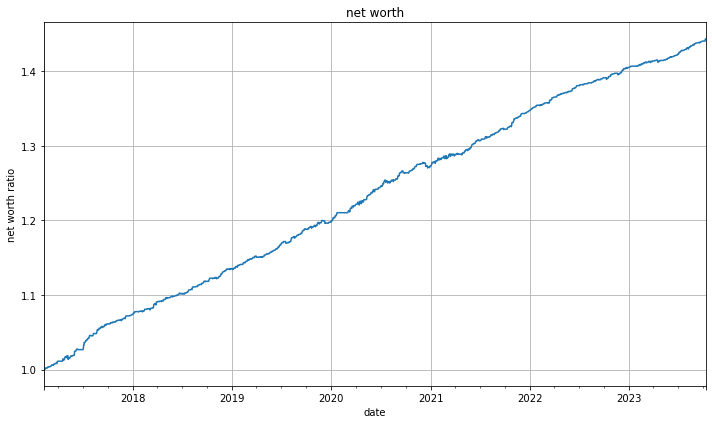

In [36]:

# 输出回测结果
%matplotlib inline
initial_capital = 800000
record_i_want, df_of_return, daily_return = backtest(initial_capital, signals_original)

In [33]:
print(result_lr['prediction'])
print(result_lr['prediction'].mean())
print(result_lr['prediction'].median())
print(result_lr['prediction'].var())
print(sum(result_lr['prediction']))
print(sum(abs(result_lr['prediction'])))
print(len(result_lr['prediction']))
print(sum(abs(result_lr['prediction'])) / len(result_lr['prediction']))

86259    0.000000
86260    0.000000
86261    0.000000
86262    0.000000
86266    0.000000
           ...   
88248    0.008213
88249   -0.007478
88250   -0.007786
88251   -0.007547
88252    0.007548
Name: prediction, Length: 1436, dtype: float64
-0.000393115436849841
0.0
5.652322200433227e-05
-0.5645137673163717
9.449008653413498
1436
0.0065800895915135785


# 尝试用lasso

In [37]:
result_lasso = []
result_lasso.append(cf.lasso_regression_rolling(df_subset, length=287))

In [68]:
result_lasso

,Unnamed: 0,date,open,high,low,close,vwap,volume,amount,id,label,prediction
86259,86259,2015-07-27,4379.0,4389.0,4266.0,4318.0,4320.0,125816.0,62600.0,JD,-1.0,0.000000
86260,86260,2015-07-28,4310.0,4470.0,4281.0,4450.0,4403.0,220974.0,83152.0,JD,-1.0,0.000000
86261,86261,2015-07-29,4459.0,4470.0,4410.0,4429.0,4435.0,152882.0,74866.0,JD,-1.0,0.000000
86262,86262,2015-07-30,4438.0,4440.0,4351.0,4378.0,4389.0,140304.0,63052.0,JD,-1.0,0.000000
86266,86266,2015-08-05,4319.0,4321.0,4202.0,4220.0,4252.0,100410.0,60746.0,JD,-1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
88248,88248,2023-09-26,4550.0,4588.0,4517.0,4557.0,4553.0,103608.0,86428.0,JD,1.0,-0.000679
88249,88249,2023-09-27,4560.0,4594.0,4552.0,4581.0,4571.0,72403.0,78071.0,JD,1.0,-0.000675
88250,88250,2023-09-28,4599.0,4603.0,4562.0,4587.0,4579.0,74160.0,62295.0,JD,1.0,-0.000677
88251,88251,2023-10-09,4501.0,4514.0,4341.0,4373.0,4415.0,99316.0,44502.0,JD,1.0,-0.000696


In [39]:

data_path = r"标记了换月日的未连续化的日级数据.csv"
data = pd.read_csv(data_path)
data['date'] = pd.to_datetime(data['date'])
results= pd.DataFrame(result_lasso[0],columns = ['id', 'date', 'label', 'prediction'])
result = data.merge(results[['id', 'date', 'label', 'prediction']], on=['id', 'date'], how='left')
result_lasso = result.dropna(subset = ['prediction'])


KeyError: 0

In [73]:
bar = 0.0003
signals_original = cf.signals_day(result_lasso, bar)
signals_original['Open_Time'] = pd.to_datetime(signals_original['Open_Time']).dt.date
daily_transactions = signals_original.groupby('Open_Time')['Position'].sum()
signals = equal_weight(signals_original, 80000)

In [74]:
signals

,Asset,Open_Time,Open_Price,Direction,Close_Time,Close_Price,Predicted_Return,Position
0,JD,2017-02-09,3333.0,-4.0,2017-02-09,3320.0,-0.001599,5332.8
1,JD,2017-02-13,3330.0,-4.0,2017-02-13,3368.0,-0.001607,5328.0
2,JD,2017-02-14,3366.0,-4.0,2017-02-14,3363.0,-0.001594,5385.6
3,JD,2017-02-15,3350.0,-4.0,2017-02-15,3314.0,-0.001592,5360.0
4,JD,2017-02-16,3321.0,-4.0,2017-02-16,3317.0,-0.001623,5313.6
...,...,...,...,...,...,...,...,...
1143,JD,2023-09-26,4550.0,-3.0,2023-09-26,4557.0,-0.000680,5460.0
1144,JD,2023-09-27,4560.0,-3.0,2023-09-27,4581.0,-0.000679,5472.0
1145,JD,2023-09-28,4599.0,-3.0,2023-09-28,4587.0,-0.000675,5518.8
1146,JD,2023-10-09,4501.0,-3.0,2023-10-09,4373.0,-0.000677,5401.2


In [75]:
signals.to_csv('lasso_0.0003.csv')

最大回撤开始日期: 2018-04-25 00:00:00
最大回撤结束日期: 2019-10-21 00:00:00
交易次数: 1148, 胜率: 51.22%, 日胜率: 51.22%, 盈亏比: 1.081, 日盈亏比: 1.081, 单笔平均盈亏: 35.431, 最大回撤: 0.025, 总收益率: 5.08%, 年化收益率: 0.75%, 夏普比率: -1.184, 卡玛比率: 0.299, 百次交易盈亏0.06600099789119107


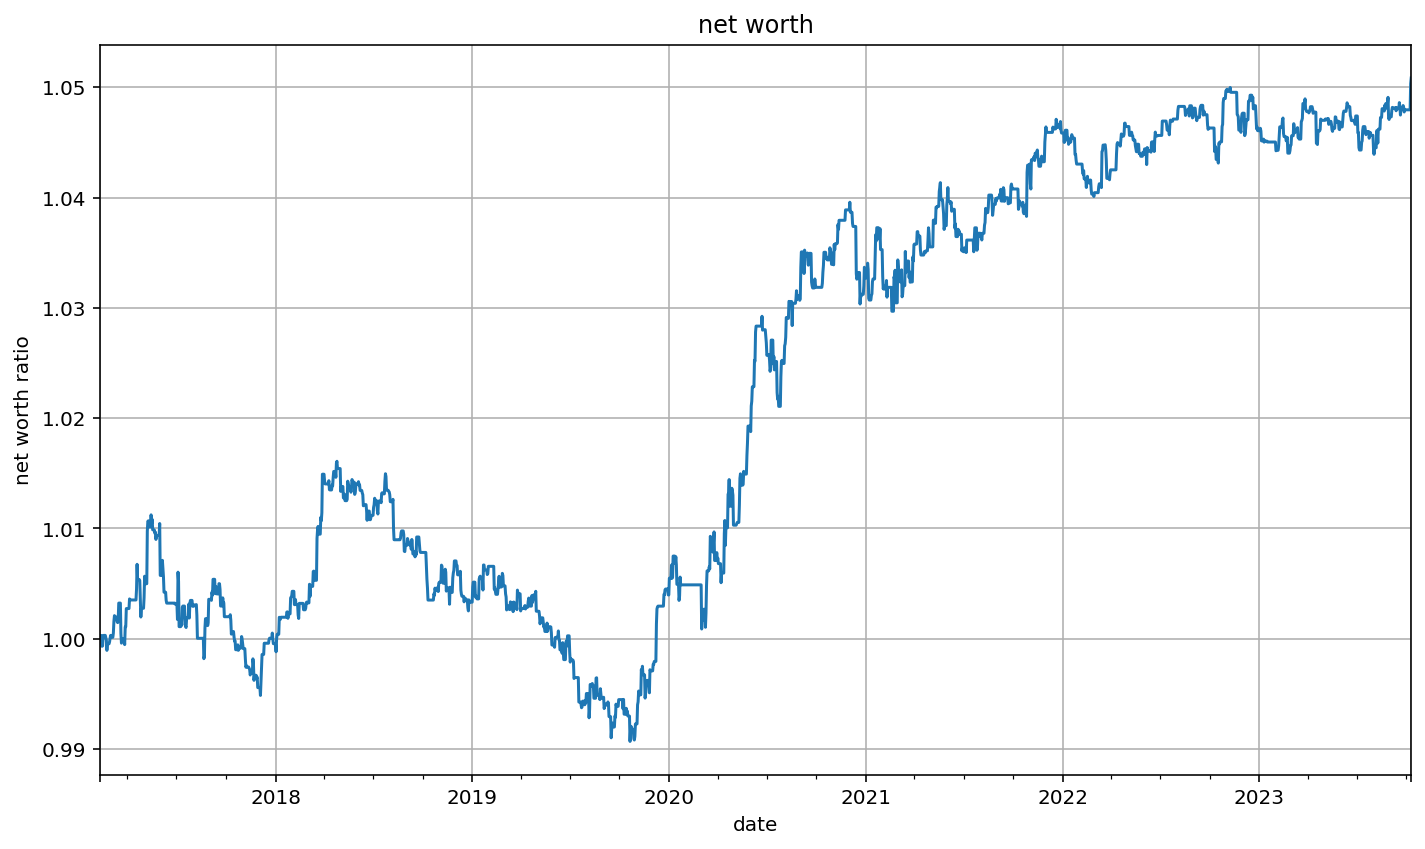

In [76]:

# 输出回测结果
initial_capital = 800000
record_i_want, df_of_return, daily_return = backtest(initial_capital, signals_original)

# 尝试使用lasso classification

In [44]:
df_subset['returns_sign'] = np.sign(df_subset['returns'])

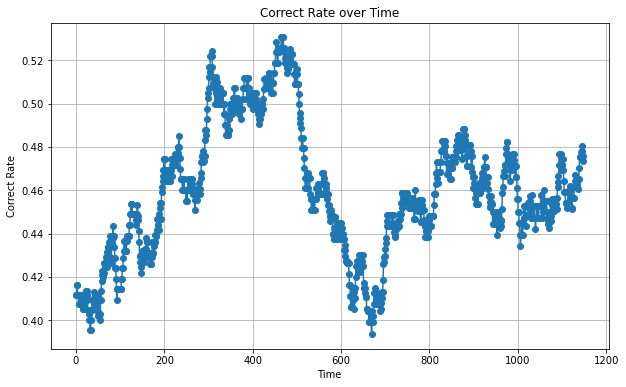

In [46]:
result_lc = []
result_lc.append(cf.lasso_regression_classification(df_subset, length=287, alpha=0.0005))


In [47]:
print(result_lc)

[            date  id  high_low_5days  high_low_17days  volume_std_2days  \
43391 2015-07-27  JD       -0.593341         3.326612         -0.778583   
43392 2015-07-28  JD        0.600364         4.182541          1.193261   
43393 2015-07-29  JD        0.499675         4.005036          0.528574   
43394 2015-07-30  JD        0.498253         3.848374         -0.830648   
43398 2015-08-05  JD        0.023393         0.331781         -0.143775   
...          ...  ..             ...              ...               ...   
45380 2023-09-26  JD       -0.199322        -0.018660         -0.685418   
45381 2023-09-27  JD       -0.554469        -0.115049         -0.451339   
45382 2023-09-28  JD       -0.554304        -0.115023         -0.951603   
45383 2023-10-09  JD        0.862717        -0.059549         -0.553602   
45384 2023-10-10  JD        0.989075         0.004542         -0.011785   

       volume_std_11days  volume_std_21days  returns_std_3days  \
43391          -0.554562        

# 测试classification 准确率

In [49]:
result_lc= result_lc[0]
test_data = result_lc[result_lc['label'] == 1]

# 计算准确率
# 对 prediction 和 return_label 进行比较，相等则为 True，不等为 False
accuracy = (test_data['prediction'] == test_data['returns_sign']).mean()

# 打印准确率
print(f"准确率为: {accuracy:.2%}")

准确率为: 48.83%


# 尝试使用svc 和 svr


In [78]:
from sklearn.svm import SVC


def svc_rolling(df, length, kernel):
    # 对标签进行数值编码
    features_delete = ['id', 'date', 'returns', 'label', 'prediction', 'returns_sign']
    # 确定特征列
    features = list(set(df.columns) - set(features_delete))

    for index, row in df.loc[df['label'] == 1].iterrows():
        start_index = index - length
        end_index = index
        if start_index < 0:
            continue  # 确保不会有负的索引

        past_df = df.loc[start_index:end_index-1]
        if past_df.empty:
            continue
        
        features = list(set(past_df.columns) - set(features_delete))
        past_feature_df = past_df[features]
        past_labels = past_df['returns_sign']

        correlations = {}
        # 对每一列计算等级相关系数
        for column in past_feature_df.columns:
            # 计算等级相关系数
            corr, _ = spearmanr(past_feature_df[column], past_labels, nan_policy='omit')  # 处理NaN值
            # 将结果存储在字典中
            correlations[column] = corr

        # 选取相关性强的特征
        features = [feature for feature, correlation in correlations.items() if abs(correlation) > 0.07125]
        if not features:
            continue

        model = SVC(kernel=kernel, class_weight='balanced')
        training_end_position = df.index.get_loc(index)
        
        # 训练模型
        if training_end_position < length:
            model.fit(past_feature_df[features], past_labels)
        else:
            model.fit(past_feature_df[features].iloc[-length:], past_labels.iloc[-length:])

        # 为当前行预测标签
        df_prediction = pd.DataFrame([row[features]], columns=features)
        df.loc[index, 'prediction'] = model.predict(df_prediction)[0]  # 预测结果需要索引[0]

    return df

In [79]:
result_svc = svc_rolling(df_subset, length=287,kernel='rbf')


In [80]:
result_svc

,date,id,high_low_5days,high_low_17days,volume_std_2days,volume_std_11days,volume_std_21days,returns_std_3days,returns_std_27days,returns_last_5days,...,wq_073,wq_074,wq_075,wq_077,wq_081,wq_083,returns,returns_sign,prediction,label
43391,2015-07-27,JD,-0.593341,3.326612,-0.778583,-0.554562,-0.994032,0.966429,2.924880,0.748141,...,0.551737,-2.704613,-0.324144,-1.093960,0.332575,-0.123209,0.03248,1.0,0.0,-1
43392,2015-07-28,JD,0.600364,4.182541,1.193261,0.514083,-0.191631,1.887834,3.193150,1.447084,...,0.826172,-3.267938,-0.323336,-0.386290,0.331742,-0.231649,-0.00673,-1.0,0.0,-1
43393,2015-07-29,JD,0.499675,4.005036,0.528574,0.625842,-0.065443,2.023421,3.133913,1.472349,...,2.184390,-2.885645,-0.322534,-1.086757,0.330915,-0.110995,-0.01352,-1.0,0.0,-1
43394,2015-07-30,JD,0.498253,3.848374,-0.830648,0.378726,-0.046768,1.978936,3.126019,0.193337,...,1.076407,-2.227037,-0.321738,-0.904503,0.330094,-0.120540,0.01005,1.0,0.0,-1
43398,2015-08-05,JD,0.023393,0.331781,-0.143775,0.067391,-0.233097,0.749202,2.950108,-1.263225,...,-1.118062,0.249131,-1.812085,0.694494,0.326870,0.153001,-0.01114,-1.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45380,2023-09-26,JD,-0.199322,-0.018660,-0.685418,1.418985,0.621197,-0.587219,0.486767,-0.142993,...,-1.366807,-1.378172,-1.343023,-0.766801,0.732794,-0.110132,0.00461,1.0,-1.0,1
45381,2023-09-27,JD,-0.554469,-0.115049,-0.451339,1.414941,0.602610,-0.331172,0.485319,-0.387742,...,-1.365910,1.269749,0.060298,-0.247732,0.732539,-1.300579,-0.00261,-1.0,1.0,1
45382,2023-09-28,JD,-0.554304,-0.115023,-0.951603,1.443363,0.606512,-1.226591,0.440665,-0.110607,...,-1.092479,1.004462,-0.965671,0.963120,0.732285,-0.423168,-0.02844,-1.0,-1.0,1
45383,2023-10-09,JD,0.862717,-0.059549,-0.553602,1.341851,0.602984,2.459702,1.183244,-1.670183,...,-1.091931,-1.113613,-0.399668,2.343911,0.732031,0.433030,-0.00664,-1.0,1.0,1


# 测试准确率

In [81]:
test_data = result_svc[result_svc['label'] == 1]

# 计算准确率
# 对 prediction 和 return_label 进行比较，相等则为 True，不等为 False
accuracy = (test_data['prediction'] == test_data['returns_sign']).mean()

# 打印准确率
print(f"准确率为: {accuracy:.2%}")

准确率为: 49.52%


In [82]:
from sklearn.svm import SVR
def svm_rolling(df, length,kernel):
    # 滚动训练所用函数， 将模型改成svm
    # 使用样本点数为length的训练集滚动训练
    features_delete = ['id', 'date', 'returns', 'label', 'prediction']
    # 确定特征列
    features = list(set(df.columns) - set(features_delete))
    for index, row in df.loc[df['label'] == 1].iterrows():
        # past_df = df[df.index < index] 
        # Apr01
        start_index = index - 286
        end_index = index
        past_df = df.loc[start_index:end_index-1]
        features = list(set(past_df.columns) - set(features_delete))

        past_feature_df = past_df[features]
        past_return = past_df['returns']
        correlations = {}
        # 对每一列计算等级相关系数
        for column in past_feature_df.columns:
            # 计算等级相关系数
            corr, _ = spearmanr(past_feature_df[column], past_return)
            # 将结果存储在字典中
            correlations[column] = corr
        features = [feature for feature, correlation in correlations.items() if abs(correlation) > 0.07125]
        if len(features) == 0:
            continue
        # 训练模型
        model = SVR(kernel=kernel)
        training_end_position = df.index.get_loc(index)
        if len(df.loc[:training_end_position]) <= length:
            model.fit(df[features].iloc[:training_end_position], df['returns'].iloc[:training_end_position])
        else:
            model.fit(df[features].iloc[training_end_position - length:training_end_position]
                      , df['returns'].iloc[training_end_position - length:training_end_position])
        # 记录预测结果
        df_prediction = pd.DataFrame([row[features]], columns=features)
        df.loc[index, 'prediction'] = model.predict(df_prediction)
    return df


In [83]:
result_svr = svm_rolling(df_subset, length=287,kernel='rbf')


In [84]:
result_svr

,date,id,high_low_5days,high_low_17days,volume_std_2days,volume_std_11days,volume_std_21days,returns_std_3days,returns_std_27days,returns_last_5days,...,wq_073,wq_074,wq_075,wq_077,wq_081,wq_083,returns,returns_sign,prediction,label
43391,2015-07-27,JD,-0.593341,3.326612,-0.778583,-0.554562,-0.994032,0.966429,2.924880,0.748141,...,0.551737,-2.704613,-0.324144,-1.093960,0.332575,-0.123209,0.03248,1.0,0.00000,-1
43392,2015-07-28,JD,0.600364,4.182541,1.193261,0.514083,-0.191631,1.887834,3.193150,1.447084,...,0.826172,-3.267938,-0.323336,-0.386290,0.331742,-0.231649,-0.00673,-1.0,0.00000,-1
43393,2015-07-29,JD,0.499675,4.005036,0.528574,0.625842,-0.065443,2.023421,3.133913,1.472349,...,2.184390,-2.885645,-0.322534,-1.086757,0.330915,-0.110995,-0.01352,-1.0,0.00000,-1
43394,2015-07-30,JD,0.498253,3.848374,-0.830648,0.378726,-0.046768,1.978936,3.126019,0.193337,...,1.076407,-2.227037,-0.321738,-0.904503,0.330094,-0.120540,0.01005,1.0,0.00000,-1
43398,2015-08-05,JD,0.023393,0.331781,-0.143775,0.067391,-0.233097,0.749202,2.950108,-1.263225,...,-1.118062,0.249131,-1.812085,0.694494,0.326870,0.153001,-0.01114,-1.0,0.00000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45380,2023-09-26,JD,-0.199322,-0.018660,-0.685418,1.418985,0.621197,-0.587219,0.486767,-0.142993,...,-1.366807,-1.378172,-1.343023,-0.766801,0.732794,-0.110132,0.00461,1.0,0.00668,1
45381,2023-09-27,JD,-0.554469,-0.115049,-0.451339,1.414941,0.602610,-0.331172,0.485319,-0.387742,...,-1.365910,1.269749,0.060298,-0.247732,0.732539,-1.300579,-0.00261,-1.0,0.00668,1
45382,2023-09-28,JD,-0.554304,-0.115023,-0.951603,1.443363,0.606512,-1.226591,0.440665,-0.110607,...,-1.092479,1.004462,-0.965671,0.963120,0.732285,-0.423168,-0.02844,-1.0,0.00668,1
45383,2023-10-09,JD,0.862717,-0.059549,-0.553602,1.341851,0.602984,2.459702,1.183244,-1.670183,...,-1.091931,-1.113613,-0.399668,2.343911,0.732031,0.433030,-0.00664,-1.0,0.00668,1


In [86]:

data_path = r"标记了换月日的未连续化的日级数据.csv"
data = pd.read_csv(data_path)
data['date'] = pd.to_datetime(data['date'])

result = data.merge(result_svr[['id', 'date', 'label', 'prediction']], on=['id', 'date'], how='left')
result_svr = result.dropna(subset = ['prediction'])


In [87]:
bar = 0.0003
signals_original = cf.signals_day(result_svr, bar)
signals_original['Open_Time'] = pd.to_datetime(signals_original['Open_Time']).dt.date
daily_transactions = signals_original.groupby('Open_Time')['Position'].sum()
signals = equal_weight(signals_original, 80000)

In [88]:
signals.to_csv('svr_0.0003.csv')

最大回撤开始日期: 2017-12-04 00:00:00
最大回撤结束日期: 2023-10-10 00:00:00
交易次数: 1148, 胜率: 46.52%, 日胜率: 46.52%, 盈亏比: 0.891, 日盈亏比: 0.891, 单笔平均盈亏: -71.093, 最大回撤: 0.113, 总收益率: -10.20%, 年化收益率: -1.60%, 夏普比率: -3.211, 卡玛比率: -0.142, 百次交易盈亏-0.12025114130434322


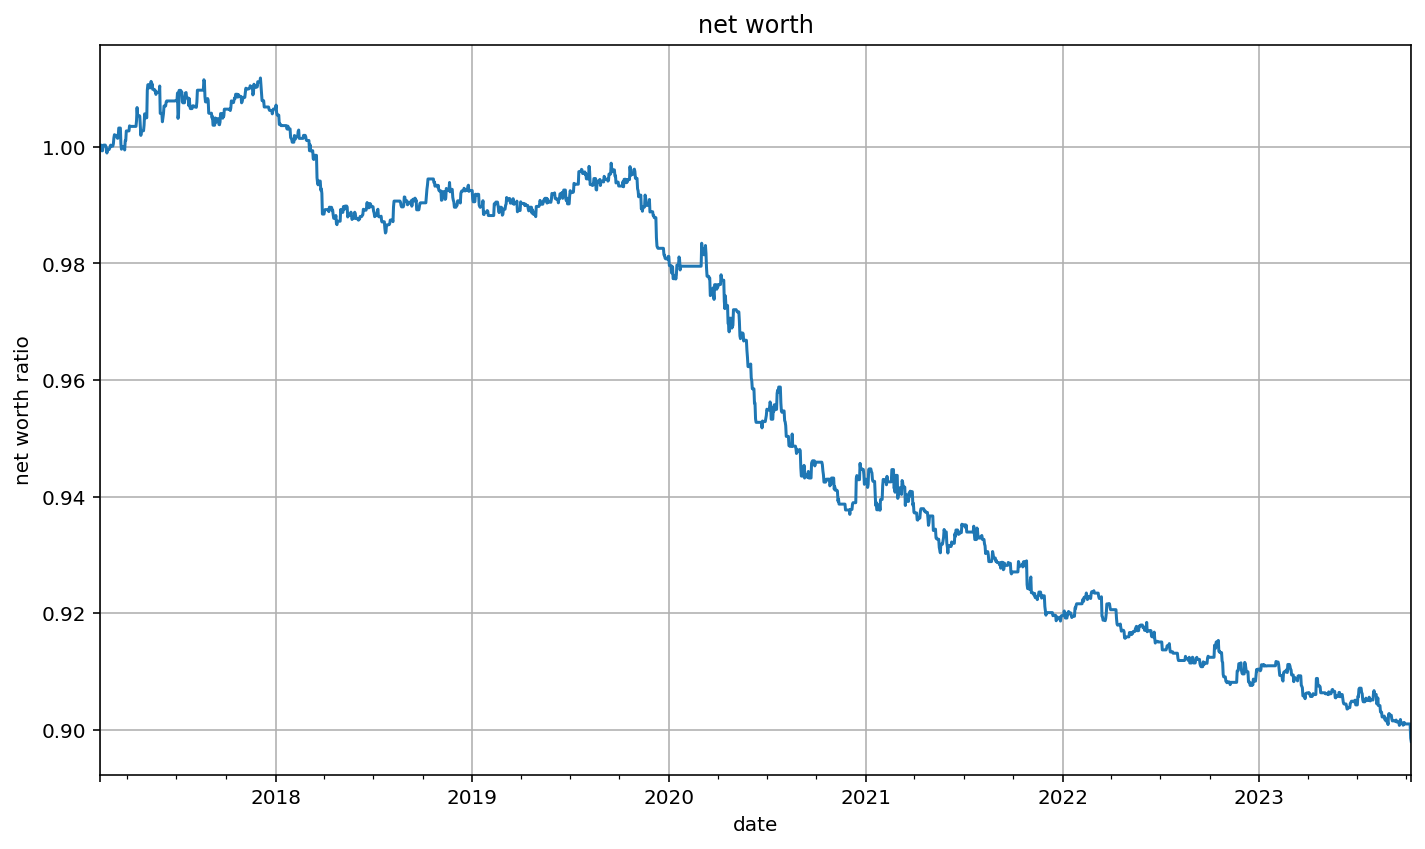

In [89]:
# 输出回测结果
initial_capital = 800000
record_i_want, df_of_return, daily_return = backtest(initial_capital, signals_original)